In [2]:
#Importing the Neccessary Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [3]:
#Importing the data
#
data = pd.read_csv("/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train_labels.csv")
train_path = "/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/"
test_path = "/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/test/"

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

So we are having <b>130908 samples labelled as Negative or Non-Cancerous</b> and <b>89117 samples labelled as positive or cancerous</b>.
So, the Negative Positive ratio is 60:40

In [4]:
#Plotting some Images with and without Cancer tissue for comparision
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_image = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b, g, r = cv2.split(bgr_image)
    rgb_image = cv2.merge([r,g,b])
    return rgb_image

Text(0, 0.5, 'Positive(Tumor) tissue samples')

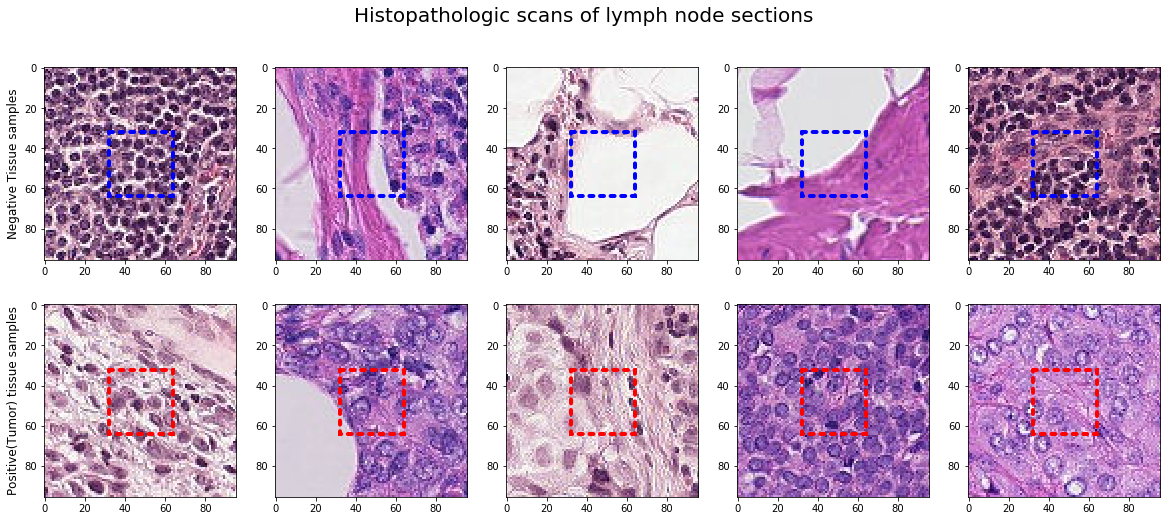

In [5]:
#Shuffling the Data and sampling it randomly
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2, 5, figsize=(20,8))
fig.suptitle("Histopathologic scans of lymph node sections", fontsize=20)

#Negatives - Meaning having no cancer
for i, idx in enumerate(shuffled_data[shuffled_data["label"] == 0]["id"][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative Tissue samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Positive(Tumor) tissue samples', size='large')

Since , it is explained about the data that, the label is influenced by only the center 32 X 32 pixels, so we are putting a rectangle patch at the center covering 32 X 32 pixels.

## Date Preprocessing and Augmentation

In any Machine Learning process, Data Preprocessing is that step in which the data gets transformed, or Encoded, to bring it to such a state that now the machine can easily parse it. In other words, the features of the data can now be easily interpreted by the algorithm.

Data preprocessing helps to build the model well and also generalizes it well.

Overfitting is a situation in which the Model learns the Training Data too well, but could not generalize Test data or any upcoming new Data.

There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions.

#### Data Augmentations we are applying:

<ul>
    <li>random rotation</li>
    <li>random crop</li>
    <li>random shift</li>
    <li>random flip</li>
    <li>random brightness</li>
    <li>random contrast</li>l
</ul>

In [6]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    return rgb_img


Text(0, 0.5, 'Tumor tissue samples')

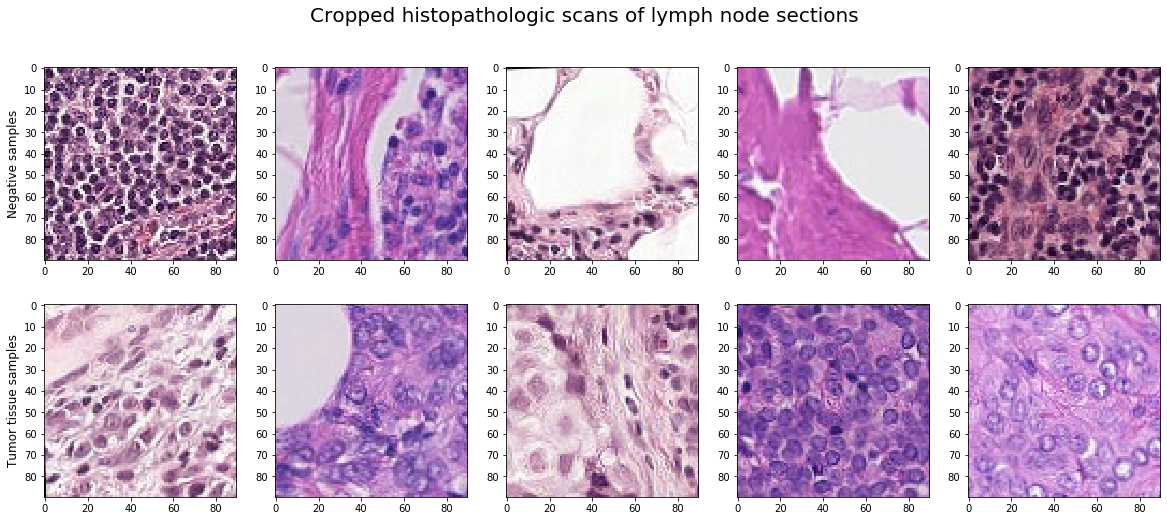

In [7]:
#Plotting data with Augmentations

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

To see the effects of our augmentation, we can plot one image multiple times.



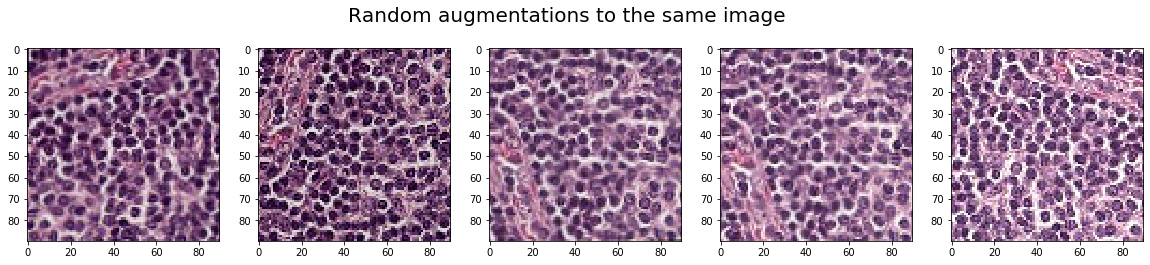

In [8]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

### Finding some Noisy data and Computing some Statistics

Checking if there are any Extremely dark or Extremely Bright Images

Also Calculating, Channel Average and Channel Standard Deviation

In [9]:
# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

(array([0.70244707, 0.54624322, 0.69645334]),
 array([0.23889325, 0.28209431, 0.21625058]))

In [10]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5a268c0241b8510465cb002c4452d63fec71028a', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '9071b424ec2e84deeb59b54d2450a6d0172cf701']


##### Plotting the Very Dark and Light Images

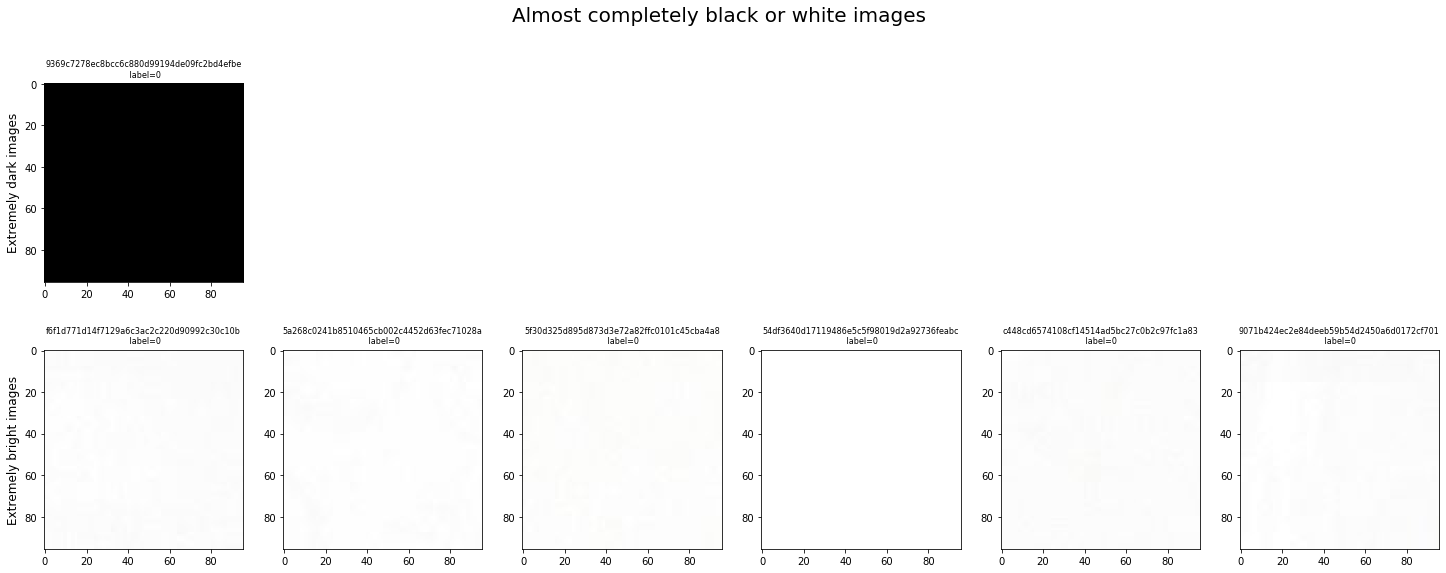

In [11]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6

So we can see that all the Dark and Bright Images are Negatively labelled

### Splitting our data into Train/Test Splits

Spliting train data to 90% training and 10% validation parts. We want to maintain equal ratios of negative/positive (60/40) in both, training and test splits. This is not so crucial here as both labels are almost equally represented but in case we had a rare class, random split could cause severe underrepresentation or in worst case, leave all rare classes out of one split.

Also we are Removing the Noisy data that we found

In [12]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#removing outliers, uncomment the four lines below
print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
train_df = train_df.drop(labels=too_dark_idx, axis=0)
train_df = train_df.drop(labels=too_bright_idx, axis=0)
print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

Before removing outliers we had 220025 training samples.
After removing outliers we have 220018 training samples.


## Model Building

Like a good Machine Learning practice, we will proceed with a baseline Model, sort of MVP(Minimum Viable Product). With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.

We will use the very famous <b>Densenet 169</b> Model and then apply transfer Learning on it, for our problem

In [13]:
# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [14]:
# creating a dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
print("Train Dict:",train_dict, "\n")
#Creating a new dataframe
df = pd.DataFrame(data=train_dict)
print("Train data Frame:\n",df.head(3), "\n")
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])
print("Test dataframe: \n", df_test.head(3))

Train Dict: {'name': array(['/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/f38a6374c348f90b587e046aac6079959adf3835',
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/755db6279dae599ebb4d39a9123cce439965282d',
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08',
       ...,
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/d4b854fe38b07fe2831ad73892b3cec877689576',
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75',
       '/home/priyanku/Desktop/6th Semester Project/Metastatic_Cancer_Detection/data/input/train/f129691c13433f66e1e0671ff1fe80

In [15]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))
    

In [16]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=[[],[]], size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

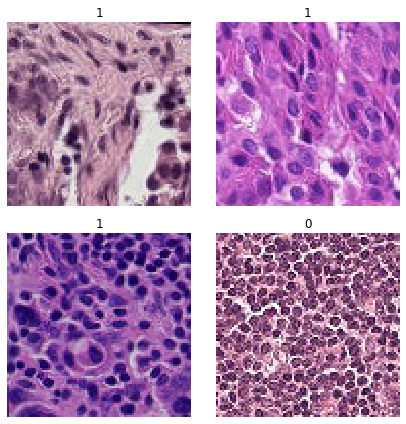

In [18]:
# check that the imgDataBunch is loading our images ok
imgDataBunch.show_batch(rows=2, figsize=(6,6))

So our Image data Bunch is loading the Images!!

### Model Training

We define a convnet learner object where we set the model architecture and our data bunch. <code>create_cnn</code> https://docs.fast.ai

In [22]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return create_cnn(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()